In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange, repeat
import rosbags
import json
import open3d as o3d
import pandas as pd
import os
import copy
from utility import listFiles
from scipy.spatial.transform import Rotation as R
from numpy import cos, sin
import torch.nn as nn
from train import LiDAR_NeRF

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [102]:
### Specifically control the data used for training:
# load data
data_path = r'datasets/training/round_plant2.npy'
with open(data_path, 'rb') as file:
    training_data_np = np.load(file)

batch = training_data_np[5060000,:]
batch = rearrange(batch, 'a -> 1 a')

In [103]:
ground_truth_distance = batch[:,0]
angles = batch[:,1:3]
origins = batch[:,3:6]
elev = angles[:,0]
pan = angles[:,1]
x_tilde, y_tilde, z_tilde = cos(elev)*cos(pan), cos(elev)*sin(pan), sin(elev)      
x_tilde_tensor = torch.tensor(x_tilde)
y_tilde_tensor = torch.tensor(y_tilde)
z_tilde_tensor = torch.tensor(z_tilde)
unit_vectors = torch.vstack([x_tilde_tensor, y_tilde_tensor, z_tilde_tensor])

In [109]:
def getSpacing(num_points, num_bins):
    """return a [num_points*num_bins, 1] pytorch tensor
    
    """
    # TODO: add hyperparameter for tuning "slope" of inverse sigmoid function
    # create a list of magnitudes with even spacing from 0 to 1
    t = torch.linspace(0,1, num_bins).expand(num_points, num_bins)  # [batch_size, num_bins//2]
    
    # preterb the spacing
    mid = (t[:, :-1] + t[:, 1:]) / 2.
    lower = torch.cat((t[:, :1], mid), -1)
    upper = torch.cat((mid, t[:, -1:]), -1)
    u = torch.rand(t.shape)
    t = lower + (upper - lower) * u  # [batch_size, nb_bins//2]
    # hard code start and end value of spacing to avoid infinity
    t[:,0] = 5e-4
    t[:,-1] = 0.995
    # apply inverse sigmoid function to even spacing
    t = rearrange(t, 'a b -> (a b) 1')  # [num_bins*batch_size, 1] 
    # t = torch.log(t / ((1 - t) + 1e-8))  
    return t  

def getSamplesEvel(centres, angles, r, num_bins = 100):
    num_points = r.shape[0]
    elev = angles[:,0]
    pan = angles[:,1]
    x_tilde, y_tilde, z_tilde = cos(elev)*cos(pan), cos(elev)*sin(pan), sin(elev)      
    unit_vectors = torch.vstack([x_tilde, y_tilde, z_tilde])

    # process vectors: [3, num_points] -> [num_points*num_bins, 3]
    unit_vectors_repeated = repeat(unit_vectors, 'c n -> (n b) c', b = num_bins)
    r_repeated = repeat(r, 'n -> (n b) 1', b = num_bins)
    t = getSpacing(num_points, num_bins)
    sample_magnitudes = t * r * 2
    pos = unit_vectors_repeated*sample_magnitudes     # [num_bins*num_points, 3]



    # tile the origin values
    centres_tiled = torch.tensor(repeat(centres, 'n c -> (n b) c', b = num_bins)) # [num_bin*batch_size, 3]
    pos = centres_tiled + pos

    # tile the angle too
    angles_tiled = torch.tensor(repeat(angles, 'n c -> (n b) c', b = num_bins))
    return pos, angles_tiled, centres_tiled

def getTargetValues(sample_positions, gt_distance, origins):
    # calculate distance from sample_position
    temp = (sample_positions - origins)**2
    pos_distance = torch.sqrt(torch.sum(temp, dim=1, keepdim=True))
    # print(pos_distance - gt_distance)
    print(gt_distance)
    
    # find the "projected" value
    sigmoid = nn.Sigmoid()
    # values = sigmoid(-(pos_distance - gt_distance))
    values = sigmoid(-(pos_distance - gt_distance))
    return values


In [110]:
sample_pos, sample_ang, sample_org = getSamplesEvel(torch.tensor(origins), torch.tensor(angles), torch.tensor(ground_truth_distance), num_bins=100)


/tmp/ipykernel_11676/2962025371.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  centres_tiled = torch.tensor(repeat(centres, 'n c -> (n b) c', b = num_bins)) # [num_bin*batch_size, 3]
/tmp/ipykernel_11676/2962025371.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  angles_tiled = torch.tensor(repeat(angles, 'n c -> (n b) c', b = num_bins))


In [111]:
#### Load the model and try to "visualize" the model's datapoints
model_evel = LiDAR_NeRF(hidden_dim=512, embedding_dim_dir=15, device = 'cpu')
model_evel.load_state_dict(torch.load('local/models/version4_trial2.pth'))
model_evel.eval(); # Set the model to inference mode

In [112]:
target_value = getTargetValues(sample_pos, ground_truth_distance, origins)
sigmoid_ = nn.Sigmoid()
rendered_value = sigmoid_(model_evel(sample_pos, sample_ang))

[3.92504032]


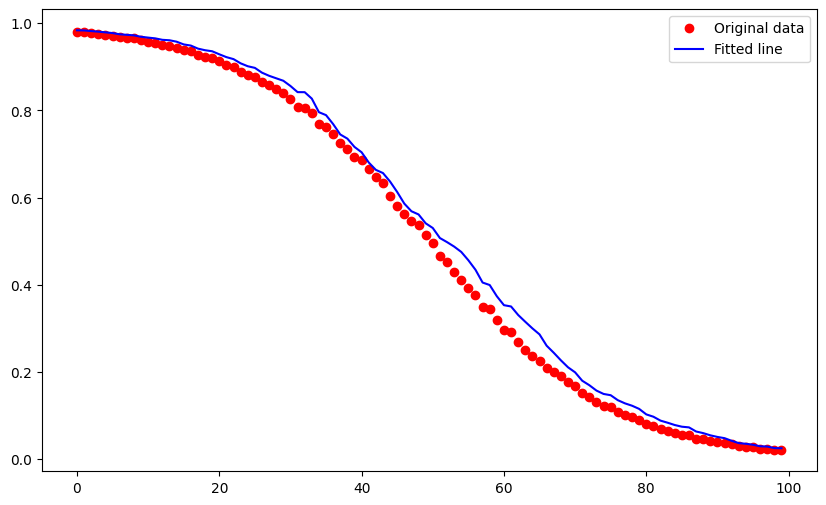

In [113]:
### plot to see:
x_axis = np.arange(100)
y_data = target_value.detach().numpy()
predicted = rendered_value.detach().numpy()


plt.figure(figsize=(10, 6))
plt.plot(x_axis, y_data, 'ro', label='Original data')
plt.plot(x_axis, predicted, 'b-', label='Fitted line')
plt.legend()
plt.show()
